# Group objects that behave in a similar way
### Assets that behave/trade in a similar way
- Volitility
- Price Return Behavior

In [ ]:
# Silence Warnings
import warnings 
warnings.simplefilter(action="ignore" , category=FutureWarning)

In [ ]:
# Fetch/Structure Data
import numpy as np 
import pandas as pd
import yfinance as yf
import pandas_datareader.nasdaq_trader as pdr


# Feature Engineering
from sklearn.preprocessing import  StandardScaler

# Machine Learning
from sklearn.cluster import  KMeans
from sklearn import metrics

# The knee point is the point of maximum curvature.
from kneed import KneeLocator

# Co-Integration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

# Reporting Visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Data Extraction

In [ ]:
# Data Storage
filename = "data-storage/raw_data_etf.csv"
filename_co_integration = "data-storage/raw_data_conint_pairs.csv"

In [ ]:
# Load Saved Data or Fetch
load_existing = True
load_coint_pairs = True

In [ ]:
# Time Range
start_date = "2023-01-01"
end_date = "2023-06-17"

### Fetch Data

In [ ]:
#  Get New Data
if not load_existing:
    symbols = pdr.get_nasdaq_symbols()
    symbols = symbols[(symbols["ETF"] == True)  &  (symbols["Market Category"] == "G")] #global markets
    symbols = list(symbols.index.values)
    
    # # create dataframe with all etf stocks data
    fetched_stocks = []
    for symbol in symbols:
        data = yf.download(symbol ,  start_date , end_date )
        data = data[["Open" , "High" , "Low" , "Close" ]].copy()
        data["Symbol"] = symbol
        fetched_stocks.append(data)
    
    # Save Data
    df = pd.concat(fetched_stocks)
    df.reset_index(inplace=True)
    df = df.pivot(index='Date', columns='Symbol', values='Close')
    df.to_csv(filename)




# READ FILE
else:
    df = pd.read_csv(filename)

# Condition Data

In [ ]:

# Drop Null Values
if df.isnull().values.any():
    df = df.dropna(axis=1)
    df = df.set_index("Date")

print("Shape: " , df.shape)
df.head()

# Feature Engineering
- For Each ETF stock
    - average returns
    - average volitility


In [ ]:
# Create Dataframe with Returns and Volitility for each stock

df_returns = pd.DataFrame(df.pct_change().mean() * 255 , columns=["Returns"])
df_returns["Volitility"] = df.pct_change().std() * np.sqrt(255)


df_returns

### Scaling Dataframe
- To make sure if one column ranges from 1 to 10 and another column ranges from 1000 to 10000

In [ ]:
# Scaling Features
scaler = StandardScaler()

# Transform Values to propper scale size
scaler = scaler.fit_transform(df_returns)

# make a new dataframe using the scaled values
scaled_data = pd.DataFrame(scaler , columns=df_returns.columns , index=df_returns.index)
df_scaled = scaled_data


df_scaled

# K MEANS CLUSTERING

### Obtain Optimal Amount of Clusters
- how many clusters until the inertia dramatically decreases?

In [ ]:
# Make a copy of your scaled dataframe
x = df_scaled.copy()

# Define amount of clusters
k = range(1,16,1)

# Create an empty list where we'll store the sum of squared distances
# (known as inertia) for each number of clusters
distortions = []

# Loop through each number of clusters in our range
for calc in k:
    # Create a KMeans model with the current number of clusters
    kmeans = KMeans(n_clusters=calc)
    
    # Fit the KMeans model to our data
    kmeans.fit(x)
    
    # Calculate the model's inertia (sum of squared distances to closest cluster)
    distortions.append(kmeans.inertia_)

# Use the KneeLocator function to find the "elbow point" in our range of clusters
# The elbow point is the number of clusters at which adding more clusters 
# does not significantly decrease the inertia (sum of squared distances).
# In this case, the function is looking for a point where the curve of the 
# distortions plot is convex and decreasing.
k1 = KneeLocator(k , distortions , curve="convex" , direction="decreasing")

# The elbow point (optimum number of clusters) is stored in `c`
Optimal_Amount_Clusters = k1.elbow

# Print out the optimum number of clusters
print("Optimum Clusters" , Optimal_Amount_Clusters)


### Fit AI knn Model

In [ ]:
# fit
k_means = KMeans(n_clusters=Optimal_Amount_Clusters)
k_means.fit(x)

In [ ]:
# predict
prediction = k_means.predict(df_scaled)

# Display Results

In [ ]:
# Obtain the centroids of the clusters from the trained KMeans model.
centroids = k_means.cluster_centers_

# Create a figure to host the plot, with size 18x10.
fig = plt.figure(figsize=(18,10))

# Add a subplot to the figure.
Graphic = fig.add_subplot(111)

# Scatter plot of the data, colored by cluster label.
scatter = Graphic.scatter(x.iloc[:,0], x.iloc[:,1] , c = k_means.labels_, cmap="rainbow" , label=x.index)

# Set the title and labels for the axes of the plot.
Graphic.set_title("KNN Cluster Results")
Graphic.set_xlabel("Mean Return")
Graphic.set_ylabel("Volatility")

# Display a color bar to illustrate which color corresponds to which cluster.
plt.colorbar(scatter)

# Plot the centroids of each cluster as green squares.
plt.plot(centroids[:,0] , centroids[:,1] , "sg" , markersize = 10)
plt.show


In [ ]:
# Return Series
clustered_series = pd.Series(index=x.index , data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=x.index , data=k_means.labels_.flatten())

# Remove outliers, denoted by -1, from the series
clustered_series = clustered_series[clustered_series != -1]


clustered_series[:15]

In [ ]:
# view number by cluser
plt.figure(figsize=(10,5))

# Generate a bar chart. X-axis is the range of the number of unique clusters. Y-axis is the count of items in each cluster.
plt.bar(range(len(clustered_series.value_counts())) , clustered_series.value_counts())

# Labels
plt.title("Clusters")
plt.xlabel("Cluster")

In [ ]:
# Remove Clusters if preferred
clusters_clean = clustered_series[clustered_series < 3]

print(f"Current Clusters: {len(clustered_series)}")
print(f"Cleaned Clusters: {len(clusters_clean)}")

# FIND Cointergrated Stock Pairs

In [ ]:
def calc_cointergration(series_1 , series_2):
    # Initialize flag
    coint_flag = 0
    
    # Perform the Augmented Dickey-Fuller test to check for stationarity
    coint_res = coint(series_1 , series_2)
    
    # Extract t-statistic, p-value and critical values from the test results
    count_t = coint_res[0]
    p_value = coint_res[1]
    critical_val = coint_res[2][1]
    
    # Perform Ordinary Least Squares (OLS) regression to find the hedge ratio
    model = sm.OLS(series_1,series_2).fit()
    hedge_ratio = model.params[0]
    
    # If p-value is less than 0.05 (5% significance level) and t-statistic is less than critical value
    # it means the two series are cointegrated and we set the flag to 1
    coint_flag = 1 if p_value< 0.05 and count_t < critical_val else 0

    return coint_flag , hedge_ratio


#### This block of code goes through a list of asset pairs, checks if they belong to the same cluster, and if they are not the same asset. Then, it checks if these pairs of assets are cointegrated, meaning they move together over time, and appends the cointegrated pairs to a list.

In [ ]:
# Initialize two lists: one for storing tested asset pairs, another for storing cointegrated asset pairs.
tested_pairs = []
cointergrated_pairs = []


if not load_coint_pairs:


    # FIND ALL COINTERGRATIONS
    for base_asset in clusters_clean.index:
        
        # BASE CLUSTER NUMBER
        base_label = clusters_clean[base_asset]

        # COMPARE AGAINST EVERY OTHER TICKER
        for compare_asset in clusters_clean.index:
            
            # COMPARISON CLUSTER NUMBER
            compare_label = clusters_clean[compare_asset]

            # CREATE PAIR STRING FOR REFERENCE & SORT
            test_pair = base_asset + compare_asset
            test_pair = "".join(sorted(test_pair))
            
            # CHECK IF TESTED ALREADY
            is_tested = test_pair in tested_pairs
            tested_pairs.append(test_pair)

            # CHECK IF BELONG TO SAME CLUSTER
            if compare_asset != base_asset and base_label == compare_label and not is_tested:
                
                # FETCH THEIR DATA
                series_1 = df[base_asset].values.astype(float)
                series_2 = df[compare_asset].values.astype(float)
                
                # FIND OUT IF COINTERGRATED OR NOT
                coint_flag , _ = calc_cointergration(series_1,series_2)
                
                if coint_flag == 1:
                    # Add this pair of assets to the list of cointegrated pairs.
                    cointergrated_pairs.append({
                        "base_asset":base_asset,
                        "compare_asset":compare_asset,
                        "label":base_label
                    })

                    print(f"{test_pair.strip()}\t | {_} | {base_label}" )


    df_coint = pd.DataFrame(cointergrated_pairs).sort_values(by="label")
    df_coint.to_csv(filename_co_integration)

In [ ]:
# READ FILE
df_coint = pd.read_csv(filename_co_integration).iloc[:, 1:]

df_coint

# TSNE DATA

In [ ]:
# get unique cointergrated assets
coin_assets = [df_coint["base_asset"].values]
coin_assets.append(df_coint["compare_asset"].values)
coin_unique_assets = np.unique(coin_assets)

coin_unique_assets

In [132]:
# Update df_TSNE to contain only the rows with index in coin_unique_assets of returns and volitility

df_TSNE = df_scaled.copy()
df_TSNE = df_TSNE[df_TSNE.index.isin(coin_unique_assets)]

df_TSNE

,Returns,Volitility
ACWI,0.338223,-0.122491
AGNG,0.293370,-0.295897
AGZD,-0.705164,-1.619825
AIQ,1.237537,0.416306
ANGL,-0.588525,-0.881308
...,...,...
VWOB,-1.218508,-0.906423
WINC,-0.716086,-1.520005
WOOD,0.242765,0.414491
XT,0.631349,0.118019


In [135]:
# Apply t-SNE transformation to df_TSNE with specific parameters
x_tsne = TSNE(learning_rate=30, perplexity=5,random_state=42, n_jobs=-1).fit_transform(df_TSNE)

x_tsne

array([[  0.51206803, -26.584814  ],
       [ -4.7900257 , -33.923904  ],
       [-47.46813   ,  -2.8752325 ],
       [ 50.01064   ,  -0.33209053],
       [-22.382671  ,  36.984455  ]], dtype=float32)

# Display TNSE
- this code is creating a map, where each point is an asset (stock). Assets that behave similarly are shown closer together. Lines between points mean those two assets have been found to move together based on a certain statistical test. The different colors represent different groups of assets that are found to be similar. The goal is to visualize how different assets relate to each other.

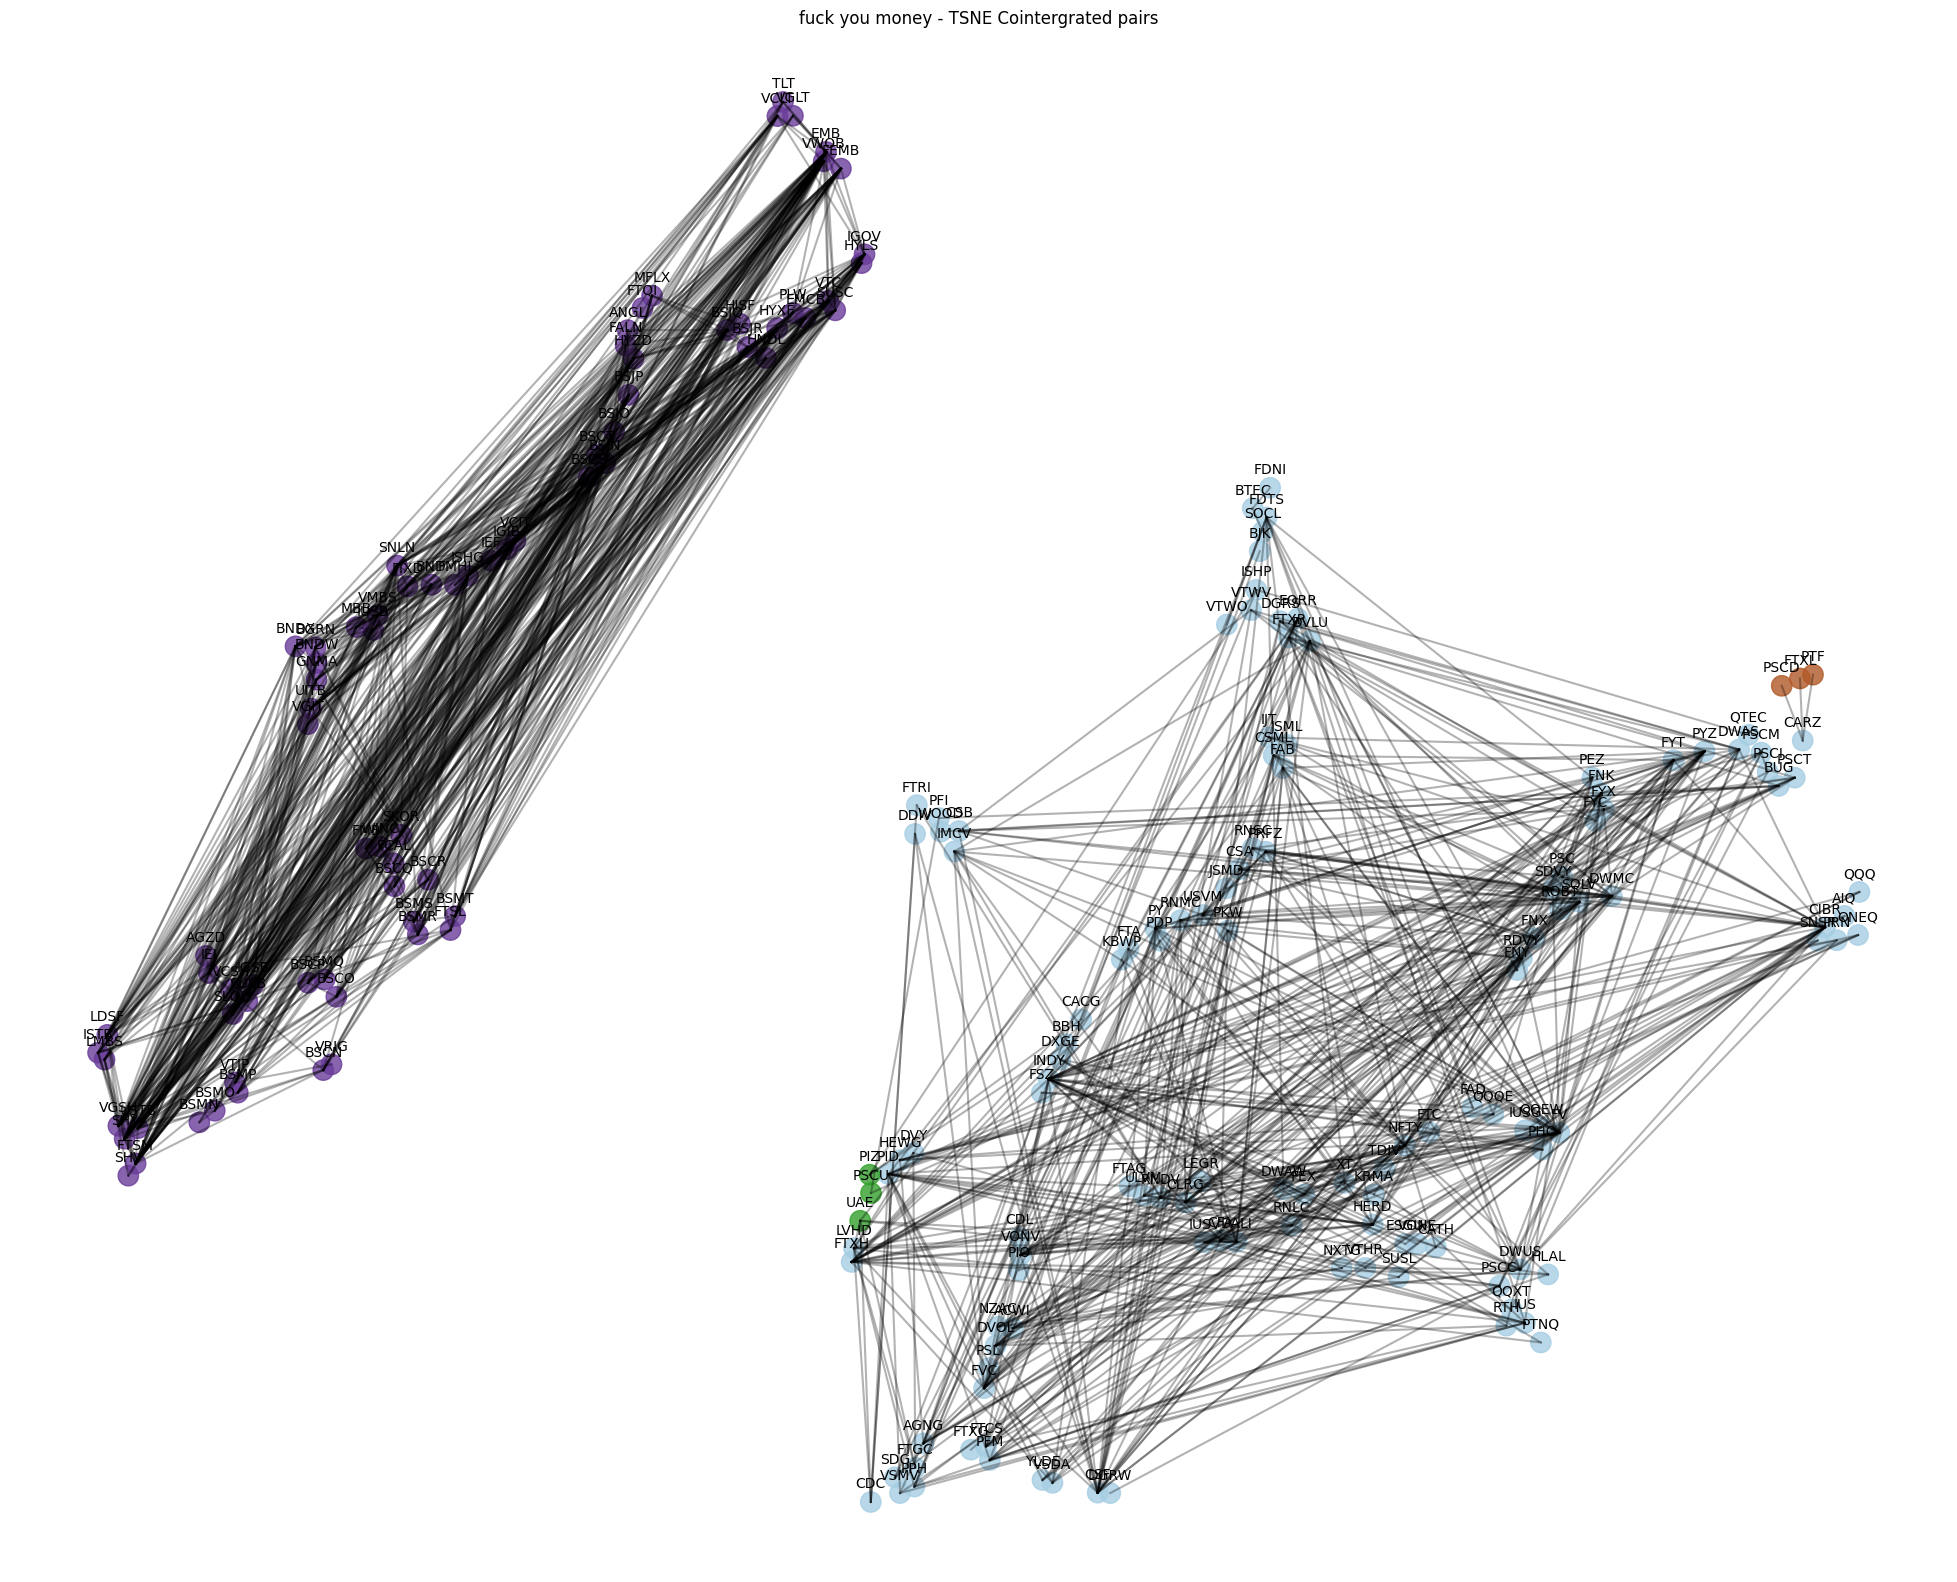

In [137]:
# Get series of clustered pairs
in_pairs_series = clustered_series.loc[coin_unique_assets]

# setup graphic figure
plt.figure(1,figsize=(25,20))
plt.clf()
plt.axis("off")


# Draw line for each pair in df_coint
for index , pair in df_coint.iterrows():
    ticker1 = pair[0]
    loc1 = df_TSNE.index.get_loc(pair[0])
    x1 , y1 = x_tsne[loc1, :]

    ticker2 = pair[1]
    loc2 = df_TSNE.index.get_loc(pair[1])
    x2 , y2 = x_tsne[loc2, :]
    plt.plot([x1,x2] , [y1,y2] , "k-" , alpha=0.3)


# Scatter plot with transformed data and color based on in_pairs_series
plt.scatter(x_tsne[:, 0] , x_tsne[: , 1] , s=215 , alpha=0.8 , c=in_pairs_series.values, cmap=cm.Paired )
plt.title("fuck you money - TSNE Cointergrated pairs")


# Add annotations for each point on the plot
for _x , _y , name in zip(x_tsne[:, 0] , x_tsne[:, 1] , df_TSNE.index):
    label = name
    plt.annotate(label , (_x,_y) , textcoords="offset points" , xytext=(0,10) , ha="center")

# final display
plt.show()